# Data processing 

In [1]:
#importing system 
import os

#importing torch 
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.transforms import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import torch.optim as optim #for gradient descent

# alexnet
import torchvision.models

#supporting libraries
import pandas
import spacy
from PIL import Image
import numpy as np
import random
import math
from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import itertools
from sklearn.preprocessing import OrdinalEncoder
import time
import copy

In [2]:
!pip install tqdm

In [3]:
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/My Drive/MIE1517_Project/Images/Images'
data_dir2 = '/content/drive/My Drive/MIE1517_Project/Images/captions.txt'

### Language Processing

In [6]:
spacy_eng = spacy.load("en")

class Vocabulary:
    def __init__(self, freq_threshold):
        
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        
        self.freq_threshold = freq_threshold
    
    def __len__(self):
        return len(self.itos)
    
    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]
    
    def build_vocabulary(self,sentences):
        idx = 4
        frequency = {}
        
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word] += 1
                
                if (frequency[word] > self.freq_threshold-1):
                  if word not in self.stoi.keys(): # added to remove duplicates
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx += 1
        return frequency        
    def numericalize(self,sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        
        return [self.stoi[word] if word in self.stoi else self.stoi["<UNK>"] for word in tokenized_text ]

In [7]:
#loading captions to a dataframe

annotation = pandas.read_csv(data_dir2)
annotation.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [8]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir=data_dir, caption_path=data_dir2, freq_threshold=5, transform=None, data_length=10000):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
    
        self.df = pandas.read_csv(caption_path)[:data_length]
        
        self.captions = self.df['caption']
        self.images = self.df['image']
        
        self.vocab = Vocabulary(freq_threshold)
        
        print(len(self.captions.tolist()))
        fre = self.vocab.build_vocabulary(self.captions.tolist())
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        caption = self.captions[index]
        image = self.images[index]
        
        img = Image.open(os.path.join(self.root_dir,image)).convert("RGB")
        
        if (self.transform):
            img = self.transform(img)
        
        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        
        numericalized_caption += self.vocab.numericalize(caption)
        
        numericalized_caption.append(self.vocab.stoi["<EOS>"])
        
        return img, torch.tensor(numericalized_caption)

In [9]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value
    
    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=True, padding_value=self.pad_value)
        
        return img, targets

In [10]:
transform = transforms.Compose(
        [
            transforms.Resize((128, 128)),
            #transforms.RandomCrop((299, 299)),
            transforms.ToTensor()
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

In [11]:
def get_loader(root_dir=data_dir, caption_path=data_dir2, transform=transform, batch_size=32, num_workers=8, shuffle=True, pin_memory=True):
    dataset = FlickrDataset(root_dir=root_dir,caption_path=caption_path, transform=transform)
    pad_value = dataset.vocab.stoi["<PAD>"]
    
    loader = DataLoader(dataset=dataset, batch_size=20, num_workers=8, shuffle=True, pin_memory=True, collate_fn=MyCollate(pad_value))
    
    return loader, dataset

In [12]:
 loader, dataset = get_loader()

10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


### Testing vocabulary function and Exploratory Data Analysis

In [13]:
df = pandas.read_csv(data_dir2)[:10000]
        
captions = df['caption']
images = df['image']
vocab = Vocabulary(50)

In [14]:
print(len(captions.tolist())) #length of vocabulary
fre = vocab.build_vocabulary(captions.tolist())

10000


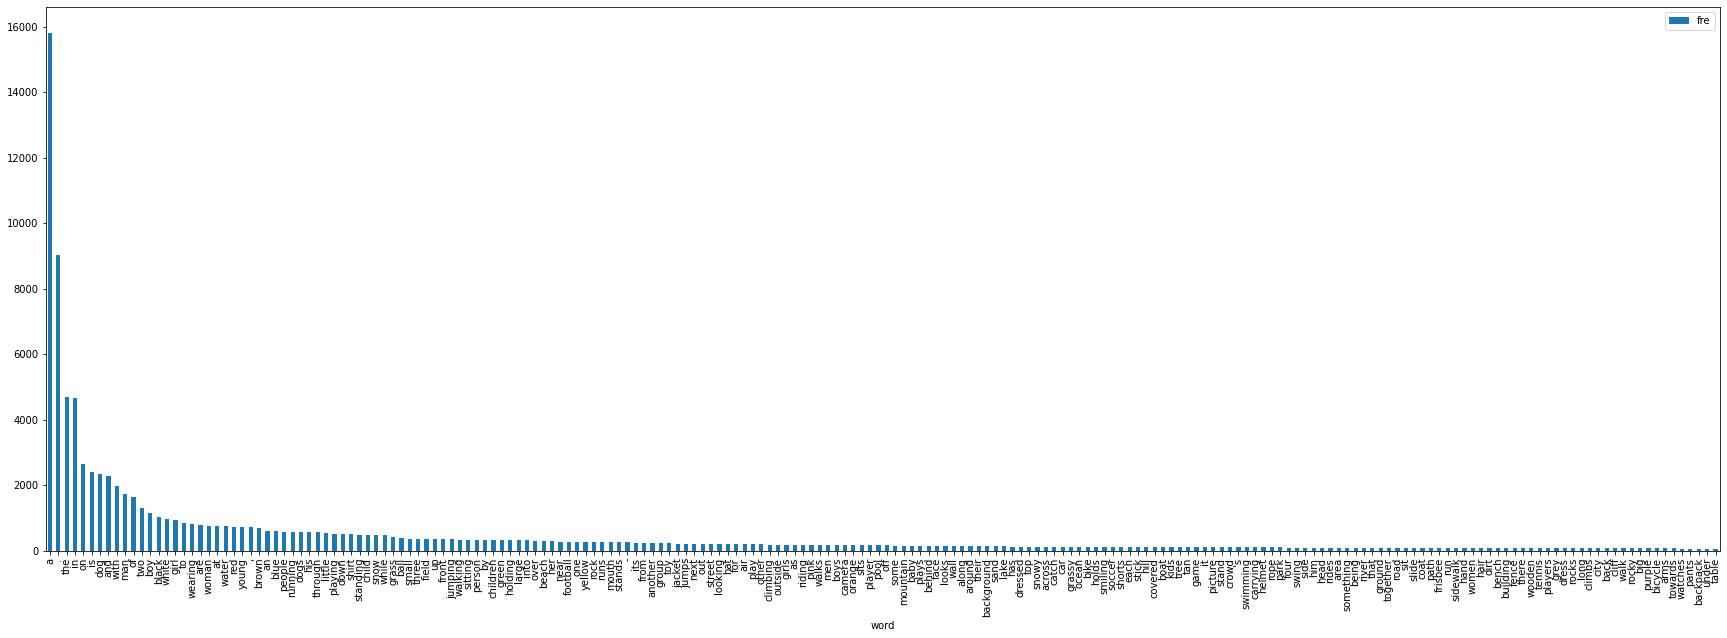

In [15]:
dffre = pandas.DataFrame(fre.items(), columns = ['word', 'fre'])
dffre = dffre.sort_values(by=['fre'], ascending=False)
dffre = dffre.head(200)
dffre.plot.bar(x='word',y='fre', figsize=(30, 10))

In [16]:
print(math.floor(random.random() * len(dataset)))

5154


In [17]:
#x, y = dataset[math.floor(random.random() * len(dataset))]
#x.shape, y.shape

(torch.Size([3, 128, 128]), torch.Size([9]))

In [18]:
for idx, (imgs, captions) in enumerate(loader):
    print(imgs.shape)
    print(captions.shape)
    break

torch.Size([20, 3, 128, 128])
torch.Size([20, 19])


KeyboardInterrupt: ignored

In [19]:
#plotting a random image and its caption from the dataset

##plt.imshow(x.permute(1,2,0))
# print(y)

# for i in y:
#     print(dataset.vocab.itos[int(i)],end=" ")

In [20]:
len(dataset.vocab.itos)

1358

# Model Training 

## CNN Model 

In [21]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self 
        
args = AttrDict()
args_dict = {
    #"model": 'inception',
    "embed_space": 4,
    'learn_rate':0.001, 
    "batch_size": 30,
    "val_split": 0.3,
    "epochs": 100,   
    "seed": 42,
    "criterion": nn.CrossEntropyLoss(),
    "use_cuda": False,
    "plot": False,
}
args.update(args_dict)

In [27]:
#Artifical Neural Network Architecture
class CNNEncoder(nn.Module):
    def __init__(self, embed_space):
        super(CNNEncoder, self).__init__()

        #if args.model == 'alexnet':
            #self.fc1 = nn.Linear(256 * 6 * 6, args.embed_space)
            #self.relu = nn.ReLU()
            #self.dropout = nn.Dropout(0.2)
        #elif args.model == 'inception':
        self.model_ft = models.inception_v3(pretrained=True, aux_logits = False)
            
        for param in self.model_ft.parameters():
            param.requires_grad = False

        #num_ftrs = model_ft.AuxLogits.fc.in_features
        #model_ft.AuxLogits.fc = nn.Linear(num_ftrs, args.embed_space)
        #num_ftrs = model_ft.fc.in_features
        self.model_ft.fc = nn.Linear(self.model_ft.fc.in_features, embed_space) 
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)   

    def forward(self, images):
        
        #if args.model == 'alexnet':
            #x = images.view(-1, 256 * 6 * 6) #flatten feature data
            #x = self.dropout(self.relu(self.fc1(x)))
        # elif args.model == 'inception':
        x1 = self.model_ft(images)
        x1 = self.dropout(self.relu(x1))
        #x2 = model_ft.AuxLogits.fc(images)
        #x2 = self.dropout(self.relu(x2))
        #x = torch.cat((x1, x2), axis=1)

        return x1

In [22]:
vocab_size = len(dataset.vocab.itos)

In [23]:
class TextGenerator(nn.Module):
    def __init__(self, embed_size, vocab_size, hidden_size, n_layers=1):
        super(TextGenerator, self).__init__()

        # recurrent neural network
        #self.rnn = nn.GRU(vocab_size, hidden_size, n_layers, batch_first=True)
        
        # identiy matrix for generating one-hot vectors
        self.ident = torch.eye(vocab_size)
        #self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, n_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)
    
    def forward(self, features, captions):
        
        inp = self.ident[captions] 
        #embeddings = self.dropout(self.embed(captions))
        #embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(inp)
        outputs = self.linear(hiddens)
        return outputs

In [24]:
class CNN_RNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(CNN_RNN, self).__init__()
        self.cnnencoder = CNNEncoder(embed_size)
        self.rnndecoder = TextGenerator(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.cnnencoder(images)
        outputs = self.rnndecoder(features, captions)
        return outputs

In [25]:
def RNN_train_cuda():
    transform = transforms.Compose([transforms.Resize((356, 356)), transforms.RandomCrop((299, 299)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_loader, dataset = get_loader(root_dir=data_dir, caption_path=data_dir2, transform=transform, batch_size=32, num_workers=2)

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Hyperparameters
    embed_size = len(dataset.vocab)
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-4
    num_epochs = 1

    model = CNN_RNN(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Only finetune the CNN
    for name, param in model.cnnencoder.model_ft.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True

    model.train()
    avg_loss = []
    for epoch in range(num_epochs):

        for idx, (imgs, captions) in tqdm(enumerate(train_loader), total=len(train_loader), leave=False):
            imgs = imgs.to(device)
            print(imgs.shape)
            captions = captions.to(device)
            print(captions.shape)
            outputs = model(imgs, captions[:,:-1])
            loss = criterion(
                outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
            )
            optimizer.zero_grad()
            loss.backward(loss)
            optimizer.step()

            avg_loss += loss
            it += 1 # increment iteration count
            if it % print_every == 0:
                print("[Iter %d] Loss %f" % (it+1, float(avg_loss/print_every)))
                #print("    " + sample_sequence_cuda(model, 140, 0.8))
                avg_loss = 0
    return model

In [ ]:
model = RNN_train_cuda()

10000


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

  0%|          | 0/500 [00:00<?, ?it/s]

torch.Size([20, 3, 299, 299])
torch.Size([20, 20])


In [ ]:
def sample_sequence_cuda(model, max_len=100, temperature=0.8):
    generated_sequence = ""
   
    inp = torch.Tensor([vocab_stoi["<BOS>"]]).long().cuda()    # <----- GPU
    hidden = None
    for p in range(max_len):
        output, hidden = model(inp.unsqueeze(0), hidden)
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp().cpu()
        top_i = int(torch.multinomial(output_dist, 1)[0])
        # Add predicted character to string and use as next input
        predicted_char = vocab_itos[top_i]
        
        if predicted_char == "<EOS>":
            break
        generated_sequence += predicted_char       
        inp = torch.Tensor([top_i]).long().cuda()    # <----- GPU
    return generated_sequence

In [ ]:
#input data to model is annotation3

def train_model(model, dataset, args):
    since = time.time()

    #assign args to common variables
    num_epochs = args.epochs
    batch_size = args.batch_size
    learn_rate = args.learn_rate
    seed = args.seed

    #select image transforms based on model chosen
    if args.model == 'inception':
        data_transform = data_transform_incep
    elif args.model == 'alexnet':
        data_transform = data_transform_alex

    #load data and create dataloaders
    dataloader = customDatasetloader(dataframe=dataset, root_dir=data_dir, transform=data_transform)
    val_size = int(len(dataset) * args.val_split)
    train_size = len(dataset) - val_size
    train_data, val_data = torch.utils.data.random_split(dataloader, [train_size, val_size], generator=torch.Generator().manual_seed(seed))    

    if args.model == 'inception':
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
        print('train_loader done')
    elif args.model == 'alexnet':
        train_data = feature_extraction_alex(train_data, args)
        val_data = feature_extraction_alex(val_data, args)
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    criterion = args.criterion
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)

    #track accuracy results    
    iters, losses, train_accs, val_accs = [], [], [], []

    #initialize best model tracking parameters
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 
    
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        running_loss = 0.0
        running_corrects = 0

        for imgs, labels in train_loader:
            
            imgs = torch.from_numpy(imgs.detach().numpy())  
            #To Enable GPU Usage
            if args.use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
                optimizer.zero_grad()

            if args.model == 'alexnet':
                # training with alexnet
                out = model(imgs, args)             # forward pass
                loss = criterion(out, labels) # compute the total loss
                loss.backward()               # backward pass (compute parameter updates)
                optimizer.step()              # make the updates for each parameter

            elif args.model == 'inception':
                # training with inception
                #outputs, aux_outputs = model(imgs)
                outputs = model(imgs, args)
                #outputs = model(inputs)[0]
                #print(outputs)
                #print(outputs.shape)
                #outputs = torch.tensor(outputs)
                #loss1 = criterion(outputs, labels)
                #loss2 = criterion(aux_outputs, labels)
                loss1 = criterion(outputs[0], labels)
                loss2 = criterion(outputs[1], labels)
                loss = loss1 + 0.4*loss2
                loss.backward()
                optimizer.step() 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, train_loader)) # compute training accuracy 
            val_acc.append(get_accuracy(model, val_data))  # compute validation accuracy

            # keep track of best train result over n
            if train_acc[n] > best_acc:
                best_acc = train_acc[n]
                best_n = n
                best_model_wts = copy.deepcopy(model.state_dict())
                
            n += 1

        # statistics
        running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        print('Loss: ', epoch_loss, 'Average Train Accuracy ', train_acc[-1])

        # Save the current model (checkpoint) to a file
        model_path = args.model + '_' + str(batch_size) + '_' + str(learning_rate) + '_' + str(epoch)
        torch.save(model.state_dict(), model_path)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
     
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = train_model(model_ft, annotation3, args) # As an example, only show the results of 2 epoch

NameError: ignored

## RNN Model

## CNN To RNN Model

## Train Function

# Evalution 

# Testing

# Appendix-Testing CNN on Small Dataset


In [ ]:
object_code = ['dogs', 'boy', 'building', 'horse'] #filtering the dataset for only images with dogs and boy

# resize all images to 224 x 224 for Alexnet model
data_transform = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

# resize all images to 299 x 299 for inception model
data_transform2 = transforms.Compose([transforms.Resize((299,299)), 
                                      transforms.ToTensor()])

# searching for images containing object_code labels
annotation2 = annotation.copy()
annotation2  = annotation2.drop_duplicates(subset='image', keep="first")
for i in object_code:
  pattern = i.replace(' ', '|')
  annotation2[i] = annotation2['caption'].str.contains(pattern, case=False, regex=True)
  annotation2[i] = annotation2[i].map({True: 1, False: 0})

annotation3  = annotation2
annotation3 = annotation3.set_index('image')
annotation3 = annotation3.drop(['caption'], axis=1)
annotation3 = annotation3.melt(ignore_index = False)
annotation3 = annotation3[annotation3.value != 0]

ord_enc = OrdinalEncoder()
annotation3["label"] = ord_enc.fit_transform(annotation3[["variable"]])
annotation3 = annotation3[['label']].astype(int)

In [ ]:
class customDatasetloader(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        dataframe['image'] = dataframe.index
        #dataframe = dataframe.drop(['value'], axis=1)
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(img_path).convert("RGB")
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))

        if self.transform:
            #image = torch.from_numpy(image).long()
            image = self.transform(image)

        return (image, y_label)

In [ ]:
#splitting data into train, validation
dataset = customDatasetloader(dataframe=annotation3,root_dir=data_dir,transform=data_transform)

train_size = int(0.7 * len(dataset))
val_size = int(len(dataset) - train_size)

train_data,val_data = torch.utils.data.random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(dataset=train_data, batch_size=100, shuffle=True) #for alexnet

In [ ]:
dataset2 = customDatasetloader(dataframe=annotation3,root_dir=data_dir,transform=data_transform2) #for inception model
train_loader2 = DataLoader(dataset=dataset2, batch_size=20, shuffle=True) #for inception model

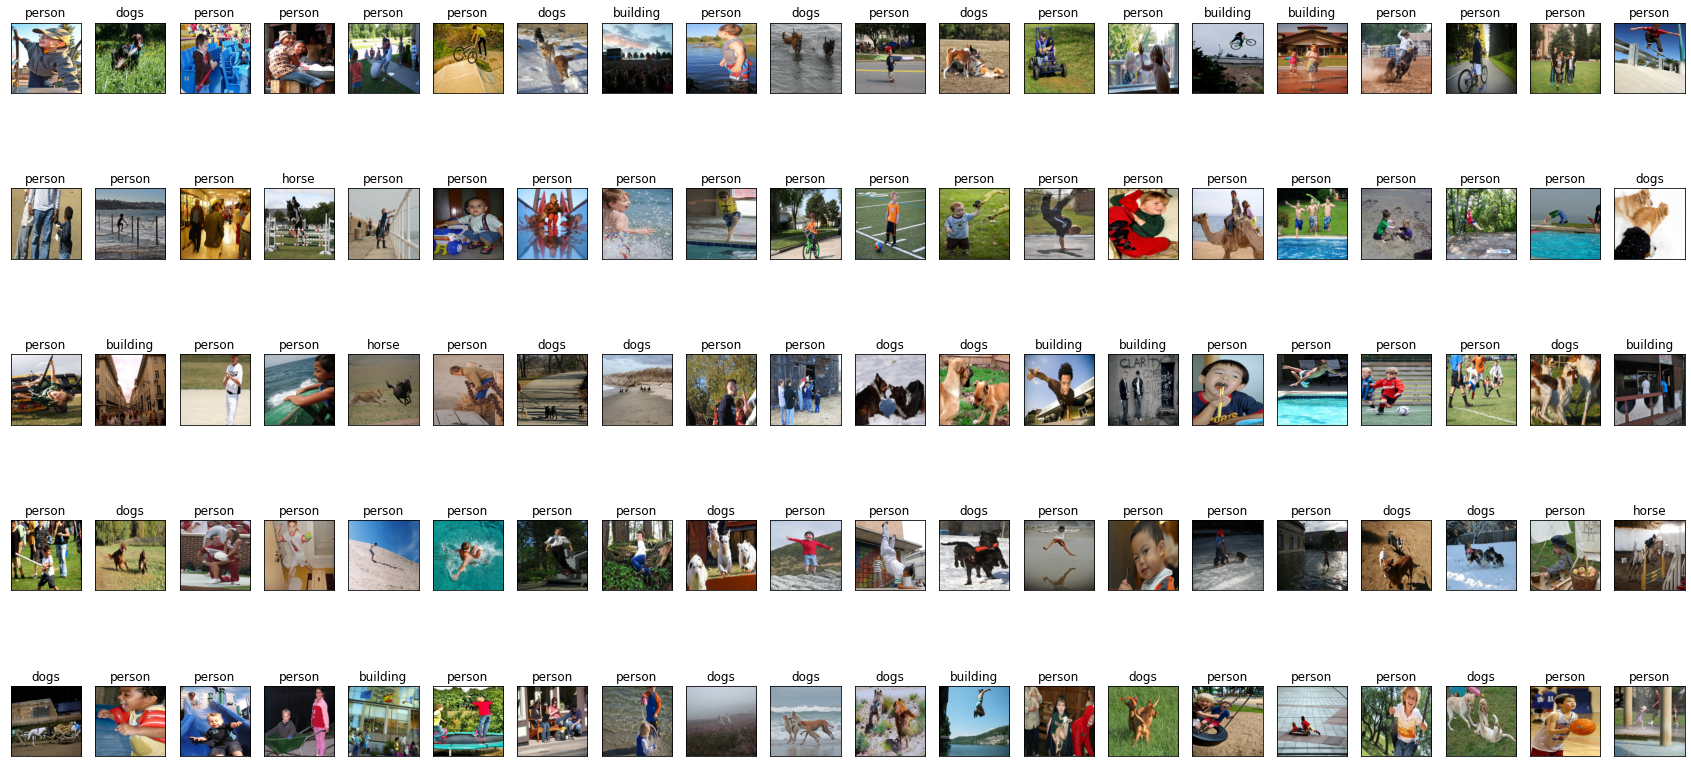

In [ ]:
# obtain one batch of training images
classes = ['person', 'building', 'dogs', 'horse']
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(30, 30))
for idx in np.arange(100):
    ax = fig.add_subplot(10, 20, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

### Testing two different Pre-trained CNN models 

## Testing AlexNet Pre-trained Model

In [ ]:
torch.manual_seed(1) # set the random seed
alexnet = torchvision.models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
def feature_extraction(dataset): #this function will extract the features for any of the datasets we have, training, validation and testing.
  data_loader=torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
  features=[]

  for i, labels in iter(data_loader):
    imgs=alexnet.features(i)
    features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
    labels=torch.stack([j for j in labels])
    features.append((features_only,labels))

  return features #this turns a list of tensors that are the images and the labels

In [ ]:
def get_accuracy(model, features):
    feature = features
    correct = 0
    total = 0
    correct_list = []
    labels_list = []
    for imgs, labels in feature:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
              
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifier(nn.Module):
    def __init__(self):
        super(ANNClassifier, self).__init__()
        self.fc1 = nn.Linear(256 * 6 * 6, 10)
        self.fc2 = nn.Linear(10, 4)

    def forward(self, x):
        x = x.view(-1, 256 * 6 * 6) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train(model, train_set, val_set, batch_size=100, lr= 0.01, num_epochs=1):
    
    features_train = feature_extraction(train_set)
    features_val = feature_extraction(val_set)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        for imgs, labels in iter(features_train):
            
            imgs = torch.from_numpy(imgs.detach().numpy())  
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, features_train)) # compute training accuracy 
            val_acc.append(get_accuracy(model, features_val))  # compute validation accuracy
            n += 1
        print('Epoch: ', epoch, 'and Iteration ', n, 'Average Train Accuracy ', train_acc[-1], 'Average Val Accuracy', val_acc[-1], 'Average Train Loss', losses[-1])
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# confirm output from AlexNet feature extraction
alexNet = torchvision.models.alexnet(pretrained=True)
features = alexNet.features(images)
features.shape

torch.Size([100, 256, 6, 6])

CUDA is available!  Training on GPU ...
Epoch:  0 and Iteration  17 Average Train Accuracy  0.7845868152274837 Average Val Accuracy 0.7467532467532467 Average Train Loss 0.034978628158569336
Epoch:  1 and Iteration  34 Average Train Accuracy  0.8310120705663882 Average Val Accuracy 0.7813852813852814 Average Train Loss 0.025482946634292604


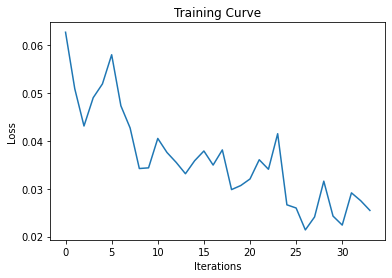

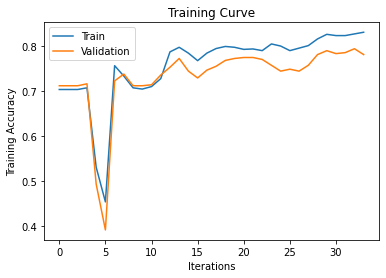

Final Training Accuracy: 0.8310120705663882
Final Validation Accuracy: 0.7813852813852814


In [ ]:
use_cuda = True

model3 = ANNClassifier()

if use_cuda and torch.cuda.is_available():
  model3.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model3, train_data, val_data, batch_size=20, lr= 0.005, num_epochs=2)

##VGG Pretrained model

In [ ]:
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# confirm output from AlexNet feature extraction
vgg16 = torchvision.models.vgg16(pretrained=True)
features = vgg16.features[:12](images)
features.shape

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


torch.Size([100, 256, 56, 56])

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifiervgg(nn.Module):
    def __init__(self):
        super(ANNClassifiervgg, self).__init__()
        self.fc1 = nn.Linear(1024, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = x.view(-1, 1024) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def feature_extraction(dataset, batch_size): #this function will extract the features for any of the datasets we have, training, validation and testing.
  data_loader=torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)
  features=[]

  for i, labels in iter(data_loader):
    imgs=vgg16.features[:12](i)
    features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
    labels=torch.stack([j for j in labels])
    features.append((features_only,labels))

  return features #this turns a list of tensors that are the images and the labels

In [ ]:
def train(model, train_set, val_set, batch_size=100, lr= 0.01, num_epochs=1):
    
    features_train = feature_extraction(train_set, batch_size)
    features_val = feature_extraction(val_set, batch_size)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        for imgs, labels in iter(features_train):
            
            imgs = torch.from_numpy(imgs.detach().numpy())  
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, features_train)) # compute training accuracy 
            val_acc.append(get_accuracy(model, features_val))  # compute validation accuracy
            n += 1
        print('Epoch: ', epoch, 'and Iteration ', n, 'Average Train Accuracy ', train_acc[-1], 'Average Val Accuracy', val_acc[-1], 'Average Train Loss', losses[-1])
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
use_cuda = True

model4= ANNClassifiervgg()

if use_cuda and torch.cuda.is_available():
  model4.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model4, train_data, val_data, batch_size=20, lr= 0.005, num_epochs=2)

CUDA is available!  Training on GPU ...


##GoogLeNet Test

In [ ]:
torch.manual_seed(1) # set the random seed
goog = torchvision.models.googlenet(pretrained=True)

In [ ]:
tens = torch.rand((1,3,224,224))
feats = nn.Sequential(*(list(goog.children())[:-1]))
feats(tens).shape

torch.Size([1, 1024, 1, 1])

In [ ]:
def feature_extraction(dataset): #this function will extract the features for any of the datasets we have, training, validation and testing.
  data_loader=torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
  features=[]

  goog = torchvision.models.googlenet(pretrained=True)

  for i, labels in iter(data_loader):
    #imgs=goog.children(i)
    imgs= feats(i)
    features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
    labels=torch.stack([j for j in labels])
    features.append((features_only,labels))

  return features #this turns a list of tensors that are the images and the labels

In [ ]:
def get_accuracy(model, features):
    feature = features
    correct = 0
    total = 0
    correct_list = []
    labels_list = []
    for imgs, labels in feature:
        
        if use_cuda and torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        #############################################
              
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

In [ ]:
#Artifical Neural Network Architecture
class ANNClassifierGoog(nn.Module):
    def __init__(self):
        super(ANNClassifierGoog, self).__init__()
        self.fc1 = nn.Linear(1024, 10)
        self.fc2 = nn.Linear(10, 2)

    def forward(self, x):
        x = x.view(-1, 1024) #flatten feature data
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
def train(model, train_set, val_set, features_train, features_val, batch_size=100, lr= 0.01, num_epochs=1):
    
    #features_train = feature_extraction(train_set)
    #features_val = feature_extraction(val_set)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()
        for imgs, labels in iter(features_train):
            
            imgs = torch.from_numpy(imgs.detach().numpy())  
            #############################################
            #To Enable GPU Usage
            if use_cuda and torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
            #############################################
            
              
            out = model(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, features_train)) # compute training accuracy 
            val_acc.append(get_accuracy(model, features_val))  # compute validation accuracy
            n += 1
        print('Epoch: ', epoch, 'and Iteration ', n, 'Average Train Accuracy ', train_acc[-1], 'Average Val Accuracy', val_acc[-1], 'Average Train Loss', losses[-1])
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# obtain one batch of training images
import time
t = time.time()

dataiter = iter(train_loader)
images, labels = dataiter.next()

# confirm output from AlexNet feature extraction
goog = torchvision.models.googlenet(pretrained=True)
#features = goog(images)
features = nn.Sequential(*(list(goog.children())[0:8]))

print(time.time() - t)

19.558084964752197


In [ ]:
features_train = feature_extraction(train_data)
features_val = feature_extraction(val_data)

In [ ]:
t = time.time()
print(t)

use_cuda = True

model6 = ANNClassifierGoog()
#model3 = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

if use_cuda and torch.cuda.is_available():
  model6.cuda()
  print('CUDA is available!  Training on GPU ...')
else:
  print('CUDA is not available.  Training on CPU ...')
  
#proper model
train(model6, train_data, val_data, features_train, features_val, batch_size=200, lr= 0.005, num_epochs=2)

print(time.time() - t)

1636599961.0168338
CUDA is available!  Training on GPU ...


## Inception Model

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    iters, losses, train_acc, val_acc = [], [], [], []
    
    # training
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        running_loss = 0.0
        running_corrects = 0

            # Iterate over data.
        for inputs, labels in dataloaders:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                #with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                if is_inception:
                  # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                  outputs, aux_outputs = model(inputs)
                  #outputs = model(inputs)[0]
                  #print(outputs)
                  #print(outputs.shape)
                  #outputs = torch.tensor(outputs)
                  iters.append(n)
                  loss1 = criterion(outputs, labels)
                  loss2 = criterion(aux_outputs, labels)
                  loss = loss1 + 0.4*loss2
                  loss.backward()
                  optimizer.step()
                  train_acc.append(get_accuracy2(model, dataloaders)) # compute training accuracy 
                  n += 1
                # statistics
                running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / len(dataloaders.dataset)

        print('Loss: ', epoch_loss, 'Average Train Accuracy ', train_acc[-1])

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
     
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def get_accuracy2(model, train_loader2):
    correct = 0
    total = 0
    correct_list = []
    labels_list = []
    for imgs, labels in train_loader2:
        
        imgs = imgs.to(device)
        labels = labels.to(device)
        #############################################
              
        outputs, _ = model(imgs)
        _, preds = torch.max(outputs, 1)
        #select index with maximum prediction score
        #pred = output.max(1, keepdim=True)[1]
       
        #correct += pred.eq(labels.view_as(pred)).sum().item()
        correct +=  torch.sum(preds == labels.data)
        total += imgs.shape[0]
        accuracy = correct / total
    return accuracy

In [ ]:
model_ft = models.inception_v3(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 2)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

#print(model_ft)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()


Epoch 0/1
----------
Loss:  0.49885090224908823 Average Train Accuracy  tensor(0.8916, device='cuda:0')
Epoch 1/1
----------
Loss:  0.3275506506800215 Average Train Accuracy  tensor(0.9355, device='cuda:0')
Training complete in 30m 10s


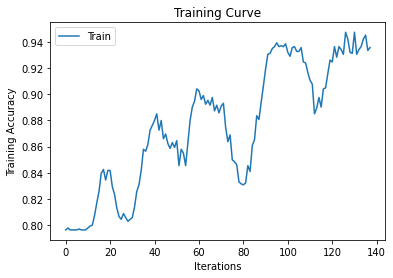

Final Training Accuracy: 0.9355311393737793


In [ ]:
model_ft = train_model(model_ft, train_loader2, criterion, optimizer_conv, num_epochs=2, is_inception=True) # As an example, only show the results of 2 epoch

## Train model with argument input (Need to check operation/integration)

In [ ]:
def feature_extraction(dataset): #this function will extract the features for any of the datasets we have, training, validation and testing.
  data_loader=torch.utils.data.DataLoader(dataset, batch_size=64,shuffle=True)
  features=[]

  for i, labels in iter(data_loader):
    imgs=alexnet.features(i)
    features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
    labels=torch.stack([j for j in labels])
    features.append((features_only,labels))

  return features #this turns a list of tensors that are the images and the labels

In [ ]:
object_code = ['dogs', 'boy', 'buildings', 'horse'] #filtering the dataset for only images with dogs and boy

# resize all images to 224 x 224 for Alexnet model
data_transform_alex = transforms.Compose([transforms.Resize((224,224)), 
                                      transforms.ToTensor()])

# resize all images to 299 x 299 for inception model
data_transform_incep = transforms.Compose([transforms.Resize((299,299)), 
                                      transforms.ToTensor()])

# searching for images containing object_code labels
annotation2 = annotation.copy()
annotation2  = annotation2.drop_duplicates(subset='image', keep="first")
for i in object_code:
  pattern = i.replace(' ', '|')
  annotation2[i] = annotation2['caption'].str.contains(pattern, case=False, regex=True)
  annotation2[i] = annotation2[i].map({True: 1, False: 0})

annotation3  = annotation2
annotation3 = annotation3.set_index('image')
annotation3 = annotation3.drop(['caption'], axis=1)
annotation3 = annotation3.melt(ignore_index = False)
annotation3 = annotation3[annotation3.value != 0]

ord_enc = OrdinalEncoder()
annotation3["label"] = ord_enc.fit_transform(annotation3[["variable"]])
annotation3 = annotation3[['label']].astype(int)

In [ ]:
class customDatasetloader(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        dataframe['image'] = dataframe.index
        #dataframe = dataframe.drop(['value'], axis=1)
        self.annotations = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        img_path = os.path.join(self.root_dir, self.annotations.iloc[index, 1])
        image = Image.open(img_path).convert("RGB")
        y_label = torch.tensor(int(self.annotations.iloc[index, 0]))

        if self.transform:
            #image = torch.from_numpy(image).long()
            image = self.transform(image)

        return (image, y_label)

In [ ]:
def feature_extraction_alex(dataset, args): #this function will extract the features for any of the datasets we have, training, validation and testing.
    data_loader=torch.utils.data.DataLoader(dataset, batch_size=args.batch_size,shuffle=True)
    features=[]
    alexnet = torchvision.models.alexnet(pretrained=True)

    for i, labels in iter(data_loader):
        imgs=alexnet.features(i)
        features_only=torch.stack([j for j in imgs]) #note that we need to stack the features for each of the images that we have in our dataset
        labels=torch.stack([j for j in labels])
        features.append((features_only,labels))
    
    print("AlexNet features extracted")

    return features #this turns a list of tensors that are the images and the labels

In [ ]:
class AttrDict(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDict, self).__init__(*args, **kwargs)
        self.__dict__ = self 
        
args = AttrDict()
args_dict = {
    "model": 'alexnet',
    'learn_rate':0.001, 
    "batch_size": 1,
    "val_split": 0.3,
    "epochs": 1,   
    "seed": 42,
    "criterion": nn.CrossEntropyLoss(),
    "use_cuda": False,
    "plot": False,
}
args.update(args_dict)

In [ ]:
def get_accuracy2(model, train_loader2):
    correct = 0
    total = 0
    correct_list = []
    labels_list = []
    for imgs, labels in train_loader2:
        
        #imgs = imgs.to(device)
        #labels = labels.to(device)
        #############################################
              
        #outputs, _ = model(imgs)
        #_, preds = torch.max(outputs, 1)
        output = model(imgs)
        #preds = torch.max(outputs, 1)
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
       
        correct += pred.eq(labels.view_as(pred)).sum().item()
        #correct +=  torch.sum(preds == labels.data)
        total += imgs.shape[0]
        accuracy = correct / total

    return accuracy

In [ ]:
#input data to model is annotation3

def train_model(model, dataset, args):
    since = time.time()

    #assign args to common variables
    num_epochs = args.epochs
    batch_size = args.batch_size
    learn_rate = args.learn_rate
    seed = args.seed

    #select image transforms based on model chosen
    if args.model == 'inception':
        data_transform = data_transform_incep
    elif args.model == 'alexnet':
        data_transform = data_transform_alex

    #load data and create dataloaders
    dataloader = customDatasetloader(dataframe=dataset, root_dir=data_dir, transform=data_transform)
    val_size = int(len(dataset) * args.val_split)
    train_size = len(dataset) - val_size
    train_data, val_data = torch.utils.data.random_split(dataloader, [train_size, val_size], generator=torch.Generator().manual_seed(seed))    

    if args.model == 'inception':
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    elif args.model == 'alexnet':
        train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)

    criterion = args.criterion
    optimizer = optim.SGD(model.parameters(), lr=learn_rate, momentum=0.9)

    #track accuracy results    
    iters, losses, train_acc, val_acc = [], [], [], []

    #initialize best model tracking parameters
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0 
    
    
    n = 0 # the number of iterations
    for epoch in range(num_epochs):
        torch.cuda.empty_cache()

        running_loss = 0.0
        running_corrects = 0

        for imgs, labels in train_loader:
            
            imgs = torch.from_numpy(imgs.detach().numpy())  
            #To Enable GPU Usage
            if args.use_cuda and torch.cuda.is_available():
                imgs = imgs.cuda()
                labels = labels.cuda()

            # zero the parameter gradients
                optimizer.zero_grad()

            if args.model == 'alexnet':
                # training with alexnet
                out = model(imgs)             # forward pass
                loss = criterion(out, labels) # compute the total loss
                loss.backward()               # backward pass (compute parameter updates)
                optimizer.step()              # make the updates for each parameter

            elif args.model == 'inception':
                # training with inception
                #outputs, aux_outputs = model(imgs)
                outputs = model(imgs)
                #outputs = model(inputs)[0]
                #print(outputs)
                #print(outputs.shape)
                #outputs = torch.tensor(outputs)
                #loss1 = criterion(outputs, labels)
                #loss2 = criterion(aux_outputs, labels)
                loss1 = criterion(outputs[0], labels)
                loss2 = criterion(outputs[1], labels)
                loss = loss1 + 0.4*loss2
                loss.backward()
                optimizer.step() 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy2(model, train_loader)) # compute training accuracy 
            #val_acc.append(get_accuracy(model, val_data))  # compute validation accuracy

            # keep track of best train result over n
            if train_acc[n] > best_acc:
                best_acc = train_acc[n]
                best_n = n
                best_model_wts = copy.deepcopy(model.state_dict())
                
            n += 1

            if n == 4:
                break

        # statistics
        running_loss += loss.item() * imgs.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        print('Loss: ', epoch_loss, 'Average Train Accuracy ', train_acc[-1])

        # Save the current model (checkpoint) to a file
        model_path = args.model + '_' + str(batch_size) + '_' + str(learn_rate) + '_' + str(epoch)
        torch.save(model.state_dict(), model_path)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
     
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    #plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    #print("Final Validation Accuracy: {}".format(val_acc[-1]))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
#Inception
model_ftincp = models.inception_v3(pretrained=True)
for param in model_ftincp.parameters():
    param.requires_grad = False

num_ftrs = model_ftincp.AuxLogits.fc.in_features
model_ftincp.AuxLogits.fc = nn.Linear(num_ftrs, 4)
num_ftrs = model_ftincp.fc.in_features
model_ftincp.fc = nn.Linear(num_ftrs, 4)

# Alexnet
model_ftalex = torchvision.models.alexnet(pretrained=True)
for param in model_ftalex.parameters():
    param.requires_grad = False

model_ftalex.classifier[6] = nn.Linear(4096,4)
#print(model_ftalex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model_ft = model_ft.to(device)

# Observe that only parameters of final layer are being optimized as
# opposed to before.
params_to_update = []
for name,param in model_ft.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)

optimizer_conv = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

criterion = nn.CrossEntropyLoss()


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Loss:  0.030002673074735472 Average Train Accuracy  0.7344521224086871
Training complete in 2m 43s


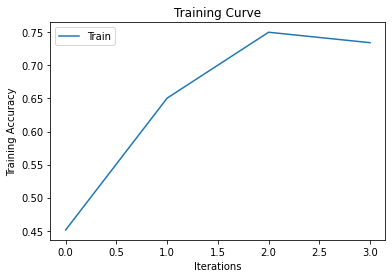

Final Training Accuracy: 0.7344521224086871


In [ ]:
model_ft = train_model(model_ftalex, annotation3, args) # As an example, only show the results of 2 epoch